# Neural Networks with PyTorch: Practical Fraud Detection

**A hands-on guide using PyTorch's built-in functions**

This notebook demonstrates:
- Feed Forward Propagation
- Backpropagation (automatic)
- Tackling Overfitting/Underfitting
- Model Evaluation
- Parameter Tuning

**Dataset**: Credit Card Fraud Detection (imbalanced classification problem)


---

## Part 1: Setup and Data Loading


In [1]:
# Install required packages
%pip install torch torchvision numpy pandas scikit-learn matplotlib seaborn -q

# Import PyTorch and essential libraries
import torch
import torch.nn as nn  # Neural network layers
import torch.optim as optim  # Optimizers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ Libraries loaded successfully!")
print(f"PyTorch version: {torch.__version__}")


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
✅ Libraries loaded successfully!
PyTorch version: 2.8.0


In [2]:
# Load or create synthetic fraud detection dataset
# Using sklearn to create a realistic imbalanced dataset
from sklearn.datasets import make_classification

# Create synthetic credit card transaction data
# 30 features (transaction characteristics)
# 2 classes: 0 = Normal, 1 = Fraud
# Imbalanced: ~1% fraud cases (realistic for fraud detection)
X, y = make_classification(
    n_samples=10000,
    n_features=30,
    n_informative=20,
    n_redundant=10,
    n_classes=2,
    n_clusters_per_class=2,
    weights=[0.99, 0.01],  # 99% normal, 1% fraud
    random_state=42
)

# Convert to DataFrame for better visualization
df = pd.DataFrame(X, columns=[f'Feature_{i+1}' for i in range(30)])
df['Class'] = y

print("Dataset Shape:", df.shape)
print("\nClass Distribution:")
print(df['Class'].value_counts())
print(f"\nFraud Rate: {(df['Class'].sum() / len(df)) * 100:.2f}%")

# Separate features and target
X = df.drop('Class', axis=1).values
y = df['Class'].values


Dataset Shape: (10000, 31)

Class Distribution:
Class
0    9849
1     151
Name: count, dtype: int64

Fraud Rate: 1.51%


In [3]:
# Data Preprocessing
# Split into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

print(f"Training set: {X_train_tensor.shape[0]} samples, {X_train_tensor.shape[1]} features")
print(f"Test set: {X_test_tensor.shape[0]} samples, {X_test_tensor.shape[1]} features")
print(f"\nTraining class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")


Training set: 8000 samples, 30 features
Test set: 2000 samples, 30 features

Training class distribution: [7879  121]
Test class distribution: [1970   30]


---

## Part 2: Building Neural Network (Using PyTorch Built-ins)

**Feed Forward Propagation**: Data flows through layers automatically when we call `model(input)`


In [4]:
# Define neural network using PyTorch's Sequential API (simplest approach)
# Architecture: Input(30) -> Hidden1(64) -> ReLU -> Hidden2(32) -> ReLU -> Output(2)

model = nn.Sequential(
    nn.Linear(30, 64),      # Input layer: 30 features -> 64 neurons
    nn.ReLU(),              # Activation function
    nn.Linear(64, 32),      # Hidden layer: 64 -> 32 neurons
    nn.ReLU(),              # Activation function
    nn.Linear(32, 2)        # Output layer: 32 -> 2 classes (Normal/Fraud)
)

print("Neural Network Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Neural Network Architecture:
Sequential(
  (0): Linear(in_features=30, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=2, bias=True)
)

Total parameters: 4,130
Trainable parameters: 4,130


In [5]:
# Demonstrate Feed Forward Propagation
# Forward pass: input -> hidden layers -> output

model.eval()  # Set to evaluation mode
with torch.no_grad():  # No gradient computation needed for inference
    # Take a single sample
    sample = X_train_tensor[0:1]  # Shape: (1, 30)
    
    # Forward propagation (automatic)
    output = model(sample)  # Shape: (1, 2)
    
    # Get predicted class
    probabilities = torch.softmax(output, dim=1)  # Convert to probabilities
    predicted_class = torch.argmax(probabilities, dim=1)
    
    print("Feed Forward Propagation Example:")
    print(f"Input shape: {sample.shape}")
    print(f"Output (logits) shape: {output.shape}")
    print(f"Output values: {output}")
    print(f"Probabilities: {probabilities}")
    print(f"Predicted class: {predicted_class.item()} (0=Normal, 1=Fraud)")
    print(f"True class: {y_train_tensor[0].item()}")


Feed Forward Propagation Example:
Input shape: torch.Size([1, 30])
Output (logits) shape: torch.Size([1, 2])
Output values: tensor([[-0.0822, -0.0283]])
Probabilities: tensor([[0.4865, 0.5135]])
Predicted class: 1 (0=Normal, 1=Fraud)
True class: 0


---

## Part 3: Training Loop (Backpropagation Automatic)

**Backpropagation**: PyTorch automatically computes gradients when we call `loss.backward()`


In [6]:
# Training setup
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training configuration
num_epochs = 50
batch_size = 64

# Lists to track metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("Starting training...")
print("=" * 60)

for epoch in range(num_epochs):
    # ===== TRAINING PHASE =====
    model.train()  # Set to training mode
    
    # Mini-batch training
    epoch_loss = 0
    correct = 0
    total = 0
    
    for i in range(0, len(X_train_tensor), batch_size):
        # Get batch
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        # Forward pass (Feed Forward Propagation)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass (Backpropagation - automatic!)
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()         # Compute gradients (backpropagation happens here)
        optimizer.step()        # Update weights using gradients
        
        # Track metrics
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    train_loss = epoch_loss / (len(X_train_tensor) // batch_size + 1)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # ===== EVALUATION PHASE =====
    model.eval()  # Set to evaluation mode
    with torch.no_grad():  # No gradient computation during evaluation
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        _, predicted = torch.max(test_outputs.data, 1)
        test_acc = (predicted == y_test_tensor).float().mean()
        
        test_losses.append(test_loss.item())
        test_accuracies.append(test_acc.item())
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Test Loss:  {test_loss.item():.4f}, Test Acc:  {test_acc.item():.4f}")

print("\n" + "=" * 60)
print("Training completed!")
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")


Starting training...
Epoch [10/50]
  Train Loss: 0.0413, Train Acc: 0.9912
  Test Loss:  0.0494, Test Acc:  0.9900
Epoch [20/50]
  Train Loss: 0.0228, Train Acc: 0.9951
  Test Loss:  0.0502, Test Acc:  0.9920
Epoch [30/50]
  Train Loss: 0.0102, Train Acc: 0.9971
  Test Loss:  0.0653, Test Acc:  0.9900
Epoch [40/50]
  Train Loss: 0.0031, Train Acc: 0.9994
  Test Loss:  0.0864, Test Acc:  0.9900
Epoch [50/50]
  Train Loss: 0.0009, Train Acc: 0.9999
  Test Loss:  0.1108, Test Acc:  0.9895

Training completed!
Final Test Accuracy: 0.9895


---

## Part 4: Visualization - Training Progress


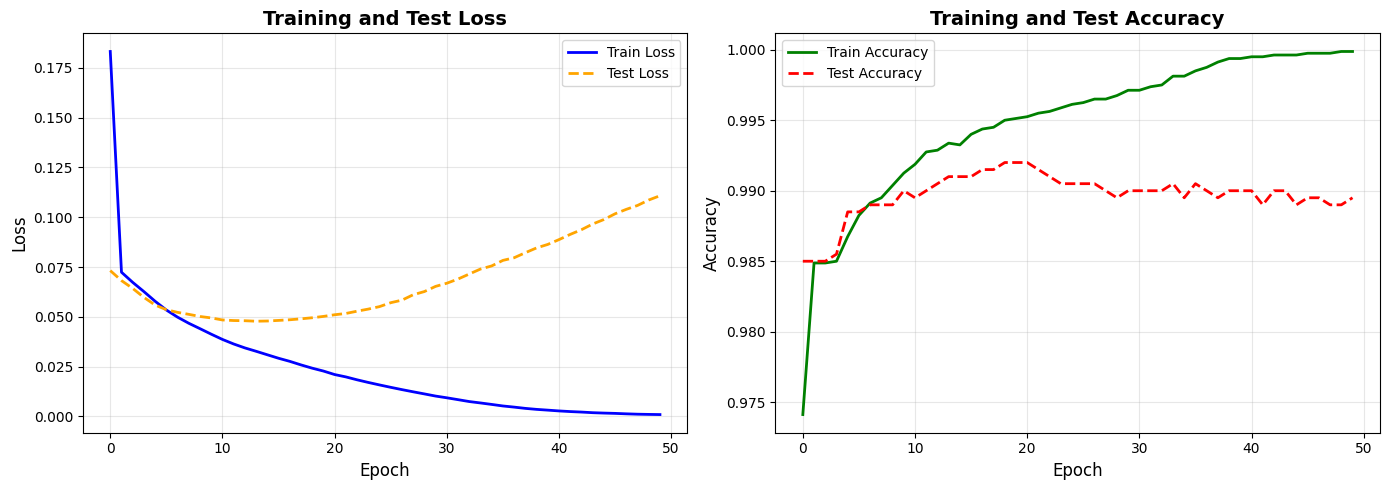


Overfitting Analysis:
Train Accuracy: 0.9999
Test Accuracy:  0.9895
Gap: 0.0104
✅ Model generalizes well!


In [7]:
# Plot training progress
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(train_losses, label='Train Loss', linewidth=2, color='blue')
axes[0].plot(test_losses, label='Test Loss', linewidth=2, color='orange', linestyle='--')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Test Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(train_accuracies, label='Train Accuracy', linewidth=2, color='green')
axes[1].plot(test_accuracies, label='Test Accuracy', linewidth=2, color='red', linestyle='--')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check for overfitting
overfitting_gap = train_accuracies[-1] - test_accuracies[-1]
print(f"\nOverfitting Analysis:")
print(f"Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Test Accuracy:  {test_accuracies[-1]:.4f}")
print(f"Gap: {overfitting_gap:.4f}")
if overfitting_gap > 0.1:
    print("⚠️ Warning: Significant overfitting detected!")
else:
    print("✅ Model generalizes well!")


---

## Part 5: Model Evaluation


In [8]:
# Make predictions on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    probabilities = torch.softmax(test_outputs, dim=1)
    predicted = torch.argmax(probabilities, dim=1)

# Convert to numpy for sklearn metrics
y_pred = predicted.numpy()
y_true = y_test

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("=" * 60)
print("Model Evaluation Metrics")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("=" * 60)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Fraud']))


Model Evaluation Metrics
Accuracy:  0.9895
Precision: 0.8000
Recall:    0.4000
F1-Score:  0.5333

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      1970
       Fraud       0.80      0.40      0.53        30

    accuracy                           0.99      2000
   macro avg       0.90      0.70      0.76      2000
weighted avg       0.99      0.99      0.99      2000



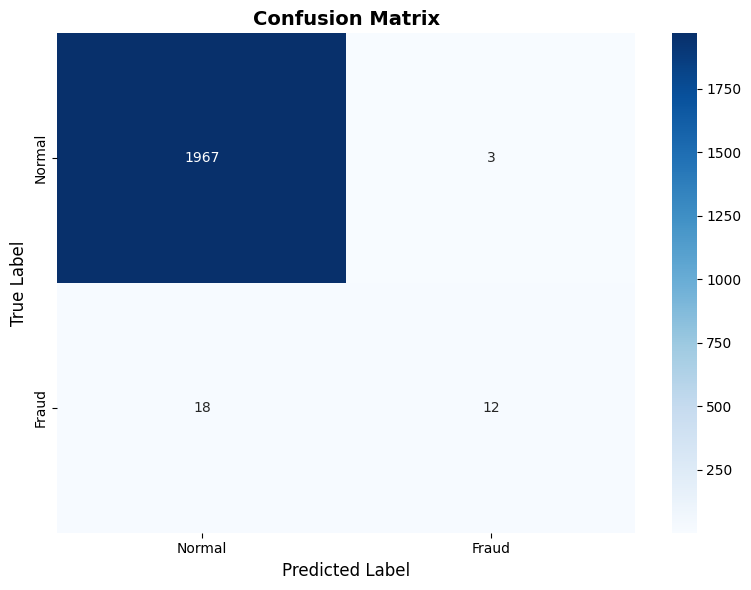


True Negatives (Normal predicted as Normal): 1967
False Positives (Normal predicted as Fraud): 3
False Negatives (Fraud predicted as Normal): 18
True Positives (Fraud predicted as Fraud): 12


In [9]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nTrue Negatives (Normal predicted as Normal): {cm[0][0]}")
print(f"False Positives (Normal predicted as Fraud): {cm[0][1]}")
print(f"False Negatives (Fraud predicted as Normal): {cm[1][0]}")
print(f"True Positives (Fraud predicted as Fraud): {cm[1][1]}")


---

## Part 6: Tackling Overfitting - Adding Dropout


In [10]:
# Create model with Dropout to prevent overfitting
# Dropout randomly turns off neurons during training (prevents over-reliance on specific neurons)

model_with_dropout = nn.Sequential(
    nn.Linear(30, 64),
    nn.ReLU(),
    nn.Dropout(0.3),  # 30% dropout - randomly turns off 30% of neurons during training
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.3),  # 30% dropout
    nn.Linear(32, 2)
)

print("Model with Dropout:")
print(model_with_dropout)

# Train model with dropout
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_dropout.parameters(), lr=0.001)

dropout_train_losses = []
dropout_train_accuracies = []
dropout_test_losses = []
dropout_test_accuracies = []

print("\nTraining model with Dropout...")
for epoch in range(num_epochs):
    # Training
    model_with_dropout.train()  # Dropout active during training
    
    epoch_loss = 0
    correct = 0
    total = 0
    
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        outputs = model_with_dropout(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    train_loss = epoch_loss / (len(X_train_tensor) // batch_size + 1)
    train_acc = correct / total
    dropout_train_losses.append(train_loss)
    dropout_train_accuracies.append(train_acc)
    
    # Evaluation (dropout automatically disabled in eval mode)
    model_with_dropout.eval()  # Dropout inactive during evaluation
    with torch.no_grad():
        test_outputs = model_with_dropout(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        _, predicted = torch.max(test_outputs.data, 1)
        test_acc = (predicted == y_test_tensor).float().mean()
        
        dropout_test_losses.append(test_loss.item())
        dropout_test_accuracies.append(test_acc.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Test Acc: {test_acc.item():.4f}")

print("\nTraining completed!")


Model with Dropout:
Sequential(
  (0): Linear(in_features=30, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)

Training model with Dropout...
Epoch [10/50] - Test Acc: 0.9855
Epoch [20/50] - Test Acc: 0.9875
Epoch [30/50] - Test Acc: 0.9890
Epoch [40/50] - Test Acc: 0.9910
Epoch [50/50] - Test Acc: 0.9910

Training completed!


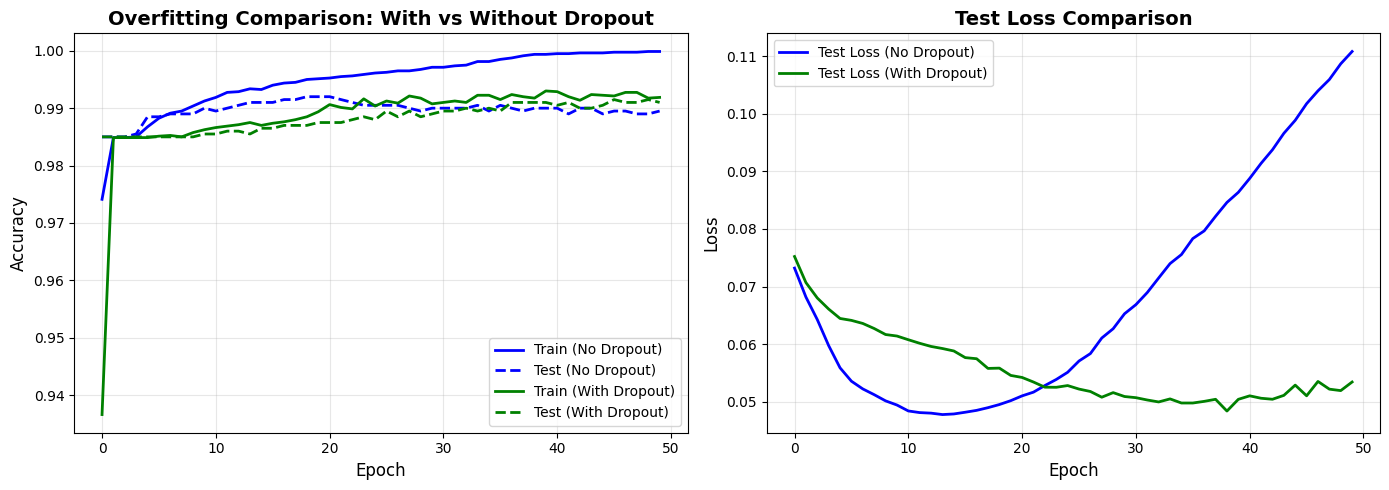


Overfitting Analysis:
Without Dropout:
  Train Acc: 0.9999, Test Acc: 0.9895
  Gap: 0.0104

With Dropout:
  Train Acc: 0.9919, Test Acc: 0.9910
  Gap: 0.0009
💡 Dropout reduces overfitting by preventing over-reliance on specific neurons!


In [11]:
# Compare models with and without dropout
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].plot(train_accuracies, label='Train (No Dropout)', linewidth=2, color='blue')
axes[0].plot(test_accuracies, label='Test (No Dropout)', linewidth=2, color='blue', linestyle='--')
axes[0].plot(dropout_train_accuracies, label='Train (With Dropout)', linewidth=2, color='green')
axes[0].plot(dropout_test_accuracies, label='Test (With Dropout)', linewidth=2, color='green', linestyle='--')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Overfitting Comparison: With vs Without Dropout', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss comparison
axes[1].plot(test_losses, label='Test Loss (No Dropout)', linewidth=2, color='blue')
axes[1].plot(dropout_test_losses, label='Test Loss (With Dropout)', linewidth=2, color='green')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Test Loss Comparison', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare final metrics
print("\n" + "=" * 60)
print("Overfitting Analysis:")
print("=" * 60)
print(f"Without Dropout:")
print(f"  Train Acc: {train_accuracies[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")
print(f"  Gap: {train_accuracies[-1] - test_accuracies[-1]:.4f}")
print(f"\nWith Dropout:")
print(f"  Train Acc: {dropout_train_accuracies[-1]:.4f}, Test Acc: {dropout_test_accuracies[-1]:.4f}")
print(f"  Gap: {dropout_train_accuracies[-1] - dropout_test_accuracies[-1]:.4f}")
print("=" * 60)
print("💡 Dropout reduces overfitting by preventing over-reliance on specific neurons!")


---

## Part 7: Parameter Tuning - Learning Rate


In [12]:
# Test different learning rates
learning_rates = [0.0001, 0.001, 0.01, 0.1]
lr_results = {}

print("Testing different learning rates...")
print("=" * 60)

for lr in learning_rates:
    # Create fresh model
    model_lr = nn.Sequential(
        nn.Linear(30, 64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(32, 2)
    )
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_lr.parameters(), lr=lr)
    
    # Train for fewer epochs for quick comparison
    test_accs = []
    for epoch in range(20):
        model_lr.train()
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]
            
            outputs = model_lr(batch_X)
            loss = criterion(outputs, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Evaluate
        model_lr.eval()
        with torch.no_grad():
            test_outputs = model_lr(X_test_tensor)
            _, predicted = torch.max(test_outputs.data, 1)
            test_acc = (predicted == y_test_tensor).float().mean()
            test_accs.append(test_acc.item())
    
    lr_results[lr] = test_accs
    print(f"LR={lr}: Final Test Acc = {test_accs[-1]:.4f}")

print("\n" + "=" * 60)


Testing different learning rates...
LR=0.0001: Final Test Acc = 0.9850
LR=0.001: Final Test Acc = 0.9895
LR=0.01: Final Test Acc = 0.9895
LR=0.1: Final Test Acc = 0.9850



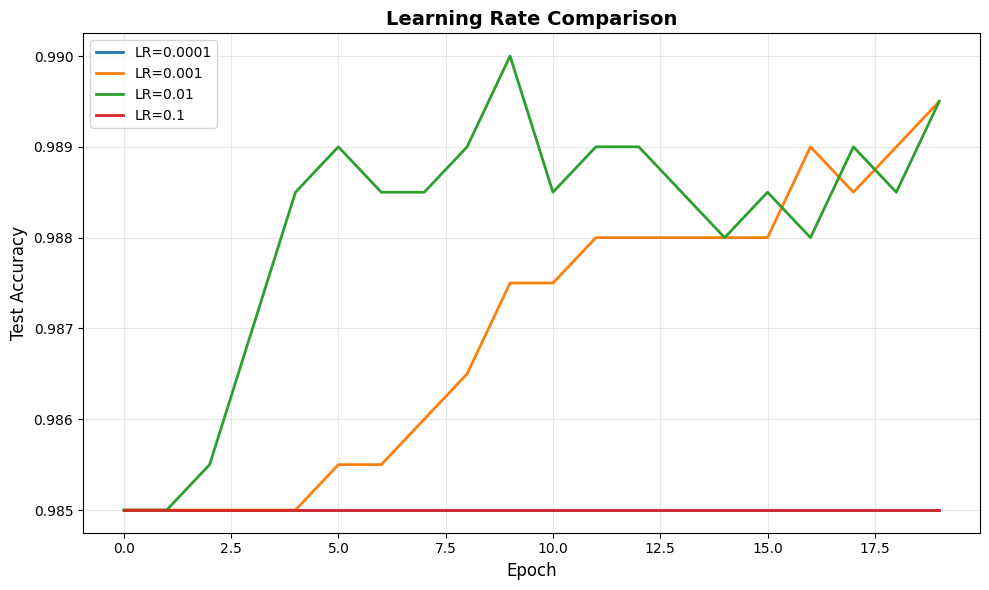


💡 Best Learning Rate: 0.001 (Test Acc: 0.9895)
💡 Too small LR: Slow convergence
💡 Too large LR: Unstable training, may not converge


In [13]:
# Visualize learning rate comparison
plt.figure(figsize=(10, 6))
for lr, accs in lr_results.items():
    plt.plot(accs, label=f'LR={lr}', linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Learning Rate Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find best learning rate
best_lr = max(lr_results.keys(), key=lambda k: lr_results[k][-1])
print(f"\n💡 Best Learning Rate: {best_lr} (Test Acc: {lr_results[best_lr][-1]:.4f})")
print("💡 Too small LR: Slow convergence")
print("💡 Too large LR: Unstable training, may not converge")


---

## Part 8: Parameter Tuning - Model Architecture


In [14]:
# Test different architectures
architectures = {
    'Small': [30, 32, 16, 2],      # Small network
    'Medium': [30, 64, 32, 2],    # Medium network (current)
    'Large': [30, 128, 64, 32, 2] # Large network
}

arch_results = {}

print("Testing different architectures...")
print("=" * 60)

for name, layers in architectures.items():
    # Build model dynamically
    modules = []
    for i in range(len(layers) - 1):
        modules.append(nn.Linear(layers[i], layers[i+1]))
        if i < len(layers) - 2:  # Don't add activation after last layer
            modules.append(nn.ReLU())
            modules.append(nn.Dropout(0.3))
    
    model_arch = nn.Sequential(*modules)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_arch.parameters(), lr=0.001)
    
    # Train
    test_accs = []
    for epoch in range(20):
        model_arch.train()
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]
            
            outputs = model_arch(batch_X)
            loss = criterion(outputs, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Evaluate
        model_arch.eval()
        with torch.no_grad():
            test_outputs = model_arch(X_test_tensor)
            _, predicted = torch.max(test_outputs.data, 1)
            test_acc = (predicted == y_test_tensor).float().mean()
            test_accs.append(test_acc.item())
    
    arch_results[name] = test_accs
    params = sum(p.numel() for p in model_arch.parameters())
    print(f"{name:8s}: Final Acc = {test_accs[-1]:.4f}, Params = {params:,}")

print("\n" + "=" * 60)


Testing different architectures...
Small   : Final Acc = 0.9875, Params = 1,554
Medium  : Final Acc = 0.9895, Params = 4,130
Large   : Final Acc = 0.9915, Params = 14,370



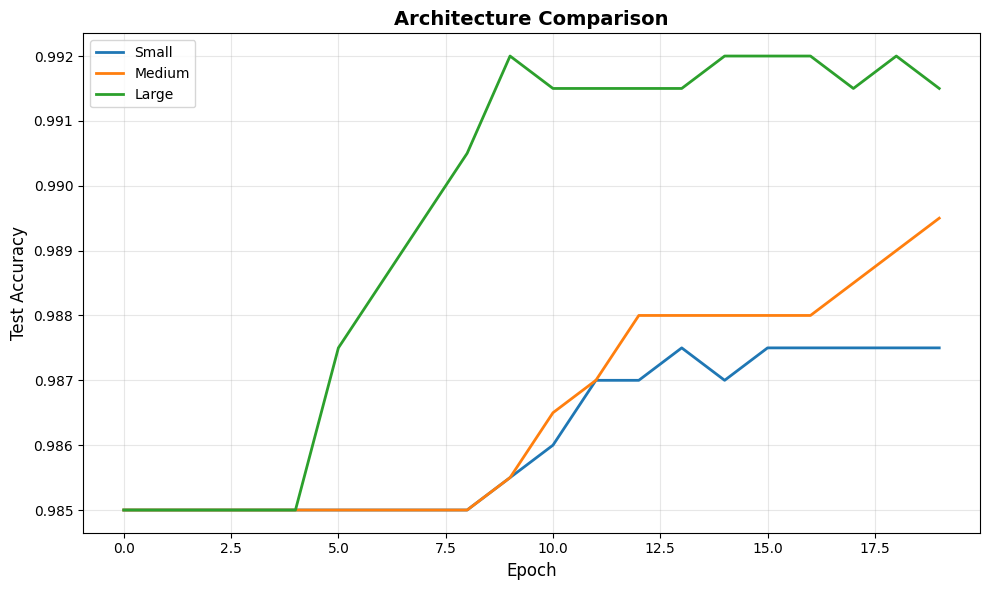


💡 Key Insights:
  • Larger networks can learn more complex patterns
  • But they're more prone to overfitting
  • Need to balance model capacity with regularization
  • For this dataset, medium architecture works well!


In [15]:
# Visualize architecture comparison
plt.figure(figsize=(10, 6))
for name, accs in arch_results.items():
    plt.plot(accs, label=name, linewidth=2)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Architecture Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Key Insights:")
print("  • Larger networks can learn more complex patterns")
print("  • But they're more prone to overfitting")
print("  • Need to balance model capacity with regularization")
print("  • For this dataset, medium architecture works well!")


---

## Summary

### Key Concepts Demonstrated:

1. **Feed Forward Propagation**: Automatic when calling `model(input)`
2. **Backpropagation**: Automatic when calling `loss.backward()`
3. **Overfitting Prevention**: Using Dropout regularization
4. **Model Evaluation**: Accuracy, Precision, Recall, F1-Score, Confusion Matrix
5. **Parameter Tuning**: Learning rate and architecture selection

### PyTorch Built-in Functions Used:
- `nn.Sequential()`: Build models easily
- `nn.Linear()`: Fully connected layers
- `nn.ReLU()`: Activation function
- `nn.Dropout()`: Regularization
- `nn.CrossEntropyLoss()`: Loss function
- `optim.Adam()`: Optimizer
- `loss.backward()`: Automatic backpropagation
- `optimizer.step()`: Weight updates

### Best Practices:
- Always use `model.train()` during training
- Always use `model.eval()` and `torch.no_grad()` during evaluation
- Standardize features before training
- Use dropout for regularization
- Tune learning rate and architecture based on validation performance
